In [23]:

# import stuff
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np

In [3]:


def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

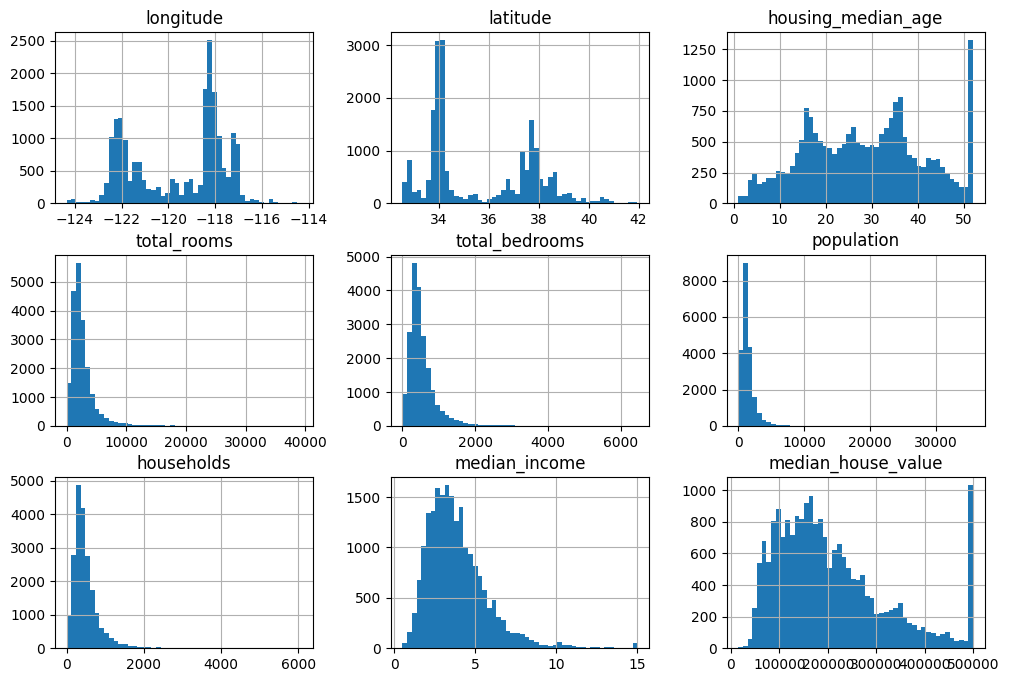

In [6]:
housing.info()

housing.hist(bins=50, figsize=(12, 8))

* housing median age is multi modal distributed > split with Kernel
* median house value has a long tail > log transformation
* feature transformation: bedrooms / rooms, persons/ households, rooms/ person

In [83]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [85]:
from sklearn.compose import ColumnTransformer, make_column_selector

def ratio_calc(X):
    '''Create a new feature that is the ratio of the second column to the first column'''
    return X[:,[0]] / X.iloc[:,[1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipe():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(ratio_calc, feature_names_out=ratio_name),
        StandardScaler()
        )

def log_pipe():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(np.log, feature_names_out='one-to-one'),
        StandardScaler()
        )

def cat_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(handle_unknown ='ignore')
    )

def num_pipe():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
        )

def rbf_pipe():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(rbf_kernel, kw_args={'mode_list':[15,35], 'gamma': 0.1}),
        StandardScaler()
    )

def clust_pipe():
    return make_pipeline(
        ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
    )



In [95]:
from sklearn import set_config

set_config(display='diagram')


sklearn.pipeline.Pipeline

In [126]:
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
# import necessary modules
# define required functions
def ratio_calc(X):
    '''Create a new feature that is the ratio of the second column to the first column'''
    return X[:,[0]] / X[:,[1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipe():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(ratio_calc, feature_names_out=ratio_name),
        StandardScaler()
        )

def log_pipe():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(np.log, feature_names_out='one-to-one'),
        StandardScaler()
        )

def cat_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(handle_unknown ='ignore')
    )

def num_pipe():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
    )

def rbf_pipe():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(rbf_transform, kw_args={'mode_list':[15,35], 'gamma': 0.1}),
        StandardScaler()
    )

def clust_pipe():
    return make_pipeline(
        ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
    )

def rbf_transform(X, mode_list, gamma=.1):
    #base_name = str(X.name)
    collect = pd.DataFrame()
    for mode in mode_list:
        kernel = pd.Series(rbf_kernel(X, [[mode]], gamma=gamma)[:,0], name=mode)
        collect = pd.concat([collect, kernel], axis=1)
    return collect

# create the preprocessing column transformer
preprocessing = ColumnTransformer([
        ("bedrooms_per_rooms", ratio_pipe(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipe(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipe(), ["population", "households"]),
        ("log", log_pipe(), ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", clust_pipe(), ["latitude", "longitude"]),
        ("cat", cat_pipeline(), make_column_selector(dtype_include=object)),
        ('rbf', rbf_pipe(), ['housing_median_age']),
        ],
    remainder=num_pipe())


housing_prepared = preprocessing.fit_transform(housing)


In [125]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

In [127]:
preprocessing.get_feature_names_out()

AttributeError: Estimator functiontransformer does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?

In [128]:
housing_prep = pd.DataFrame(housing_prepared)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>],
       [<Axes: title={'center': '5'}>, <Axes: title={'center': '6'}>,
        <Axes: title={'center': '7'}>, <Axes: title={'center': '8'}>,
        <Axes: title={'center': '9'}>],
       [<Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>,
        <Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
        <Axes: title={'center': '14'}>],
       [<Axes: title={'center': '15'}>, <Axes: title={'center': '16'}>,
        <Axes: title={'center': '17'}>, <Axes: title={'center': '18'}>,
        <Axes: title={'center': '19'}>],
       [<Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>,
        <Axes: title={'center': '24'}>],
       [<Axes: title={'center': '25'}>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: 

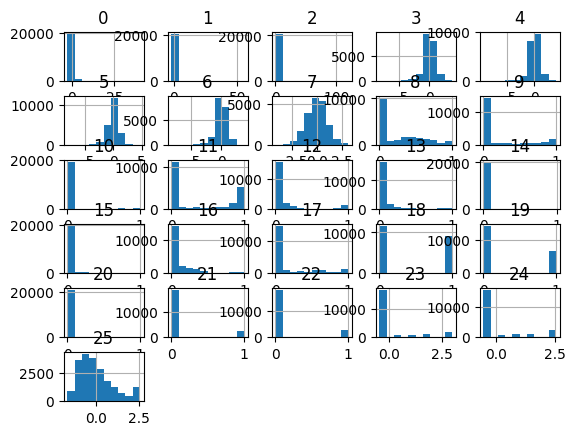

In [135]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

<Axes: ylabel='Frequency'>

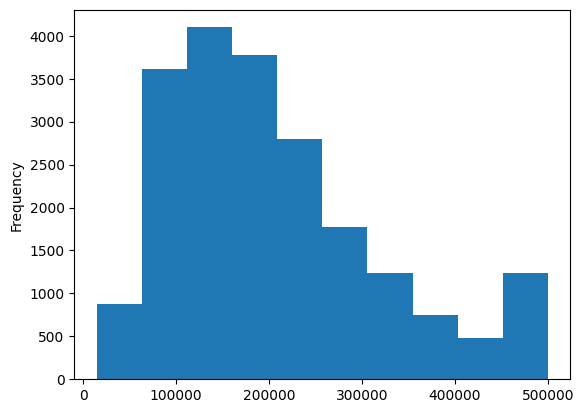

In [139]:
housing.median_house_value.plot(kind='hist')

In [141]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [145]:
y = housing['median_house_value']

In [151]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

In [152]:
X = housing

In [159]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [160]:
X_prep = preprocessing.fit_transform(X_train)

In [161]:
from sklearn.pipeline import Pipeline

In [165]:
svr_pipe = Pipeline([
    ('preprocessing',preprocessing),
    ('svr_rbf', SVR(kernel='linear'))
    ]
)

svr_pipe.fit(X_train.iloc[:5000,:], y_train[:5000])

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_per_rooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name a...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021B9E86B210>),
                                                 ('rbf',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function rbf_transform at 0x0000021B9E85BA60>,
                                                                                       kw_args={'gamma': 0.1,
                                                                                                'mode_list': [15,
                                                                                                              35]})),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['housing_median_age'])])),
                ('svr_rbf', SVR(kernel='linear'))])

In [166]:
train_pred = svr_pipe.predict(X_train)

<Axes: xlabel='median_house_value'>

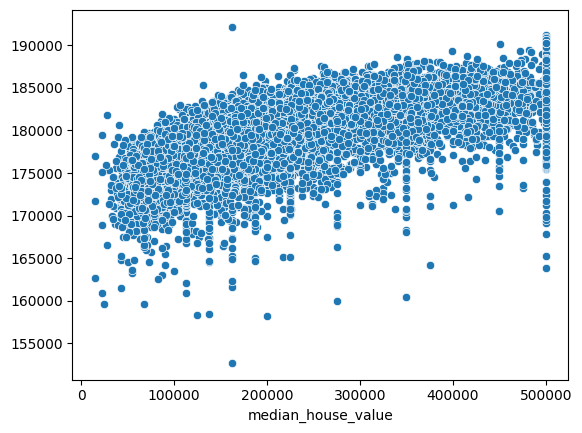

In [167]:
sns.scatterplot(x=y_train, y=train_pred)

In [175]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score

In [173]:
root_mean_squared_error(y_train, train_pred) / np.mean(y_train)

0.560127960339609

In [177]:
svr_cross = -cross_val_score(svr_pipe, X=X_train.iloc[:10000,:], y=y_train[:10000],
            scoring='neg_root_mean_squared_error', cv=5)

In [180]:
pd.Series(svr_cross).describe() / np.mean(y_train)

count    0.000024
mean     0.557094
std      0.006763
min      0.548952
25%      0.550494
50%      0.561586
75%      0.561767
max      0.562670
dtype: float64

In [189]:
svr_pipe = Pipeline([
    ('preprocessing',preprocessing),
    ('svr_rbf', SVR())
    ]
)

In [183]:
svr_cross_rbf = -cross_val_score(svr_pipe_rbf, X=X_train.iloc[:10000,:], y=y_train[:10000],
            scoring='neg_root_mean_squared_error', cv=5)

pd.Series(svr_cross_rbf).describe()

count         5.000000
mean     118403.779487
std        1545.971752
min      116559.422107
25%      116873.521500
50%      119461.054023
75%      119479.061448
max      119645.838358
dtype: float64

In [186]:
from sklearn.model_selection import GridSearchCV

In [195]:
# grid search 
# list of dictionaries

svr_pipe = Pipeline([
    ('preprocessing',preprocessing),
    ('svr', SVR())
    ]
)

param_grid = [
        {'svr__kernel': ['linear'], 'svr__C': [10., 30., 100., 300., 1000.,
                                               3000., 10000., 30000.0]},
        {'svr__kernel': ['rbf'], 'svr__C': [1.0, 3.0, 10., 30., 100., 300.,
                                            1000.0],
         'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
    ]

svr_grid = GridSearchCV(svr_pipe,
                        param_grid,
                        cv=3,
                        scoring='neg_root_mean_squared_error'
            )

In [196]:
svr_grid.fit(X=X_train.iloc[:10000,:], y=y_train[:10000])





GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms_per_rooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_na...
                                                                                                                       'mode_list': [15,
                                                                                                                                     35]})),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['housing_median_age'])])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                     10000.0, 30000.0],
                          'svr__kernel': ['linear']},
                         {'svr__C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                     1000.0],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

In [198]:
-svr_grid.best_score_

72676.6553284138

In [199]:
svr_grid.best_params_

{'svr__C': 3000.0, 'svr__kernel': 'linear'}

In [200]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, loguniform

<Axes: ylabel='Count'>

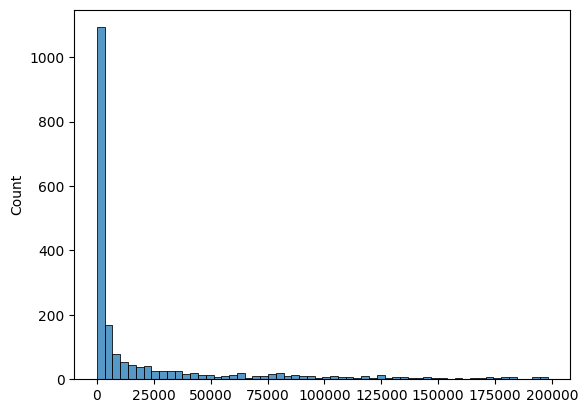

In [210]:
x = np.linspace(20,2000)

#sns.histplot(expon(scale=1).rvs(size=2000))
sns.histplot(loguniform.rvs(20,200_000, size=2000))

In [216]:
rand_grid = {'svr__kernel':['linear', 'rbf'], 
             'svr__C': loguniform(20,100_000),
             'svr__gamma': expon(scale=1.0)
             }



In [217]:
rnd_search = RandomizedSearchCV(svr_pipe,
                                param_distributions=rand_grid,
                                n_iter=50, cv=3,
                                scoring='neg_root_mean_squared_error',
                                random_state=42)

rnd_search.fit(X_train.iloc[:10000,:], y_train[:10000])




RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms_per_rooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feat...
                                                                                                StandardScaler())]),
                                                                               ['housing_median_age'])])),
                                             ('svr', SVR())]),
                   n_iter=50,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000021BAF16F290>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000021BAF16F610>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [218]:
rnd_search.best_score_

-57689.1965625089

In [220]:
root_mean_squared_error(rnd_search.predict(X_test), y_test) / np.mean(y_test)

0.27795775823765934

In [221]:
rnd_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_per_rooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name a...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021BAF004B10>),
                                                 ('rbf',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function rbf_transform at 0x0000021B9E85BA60>,
                                                                                       kw_args={'gamma': 0.1,
                                                                                                'mode_list': [15,
                                                                                                              35]})),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['housing_median_age'])])),
                ('svr', SVR(C=79969.14475809233, gamma=0.26497040005002437))])

In [223]:
import joblib

joblib.dump(rnd_search.best_estimator_, "svr_housing.pkl")

['svr_housing.pkl']